BloomTech Data Science

*Unit 2, Sprint 1, Module 3*

---

In [66]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Ridge Regression

For this project, you'll return to the Tribecca Condo dataset. But this time, you'll look at the _entire_ dataset and try to predict property sale prices.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

## Directions

The tasks for this project are the following:

- **Task 1:** Import `csv` file using `wrangle` function.
- **Task 2:** Conduct exploratory data analysis (EDA), and modify `wrangle` function to engineer two subset your dataset to one-family dwellings whose price is between \\$100,000 and \\$2,000,000.
- **Task 3:** Split data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline mean absolute error for your dataset.
- **Task 6:** Build and train a `OneHotEncoder`, and transform `X_train` and `X_test`.
- **Task 7:** Build and train a `LinearRegression` model.
- **Task 8:** Build and train a `Ridge` model.
- **Task 9:** Calculate the training and test mean absolute error for your `LinearRegression` model.
- **Task 10:** Calculate the training and test mean absolute error for your `Ridge` model.
- **Task 11:** Create a horizontal bar chart showing the 10 most influencial features for your `Ridge` model. 

**Note**

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `sklearn`

# I. Wrangle Data

In [67]:
def wrangle(filepath):
    # Import csv file
    cols = ['BOROUGH', 'NEIGHBORHOOD',
            'BUILDING CLASS CATEGORY', 'GROSS SQUARE FEET',  
            'YEAR BUILT', 'SALE PRICE', 'SALE DATE']
    df = pd.read_csv(filepath, usecols=cols,index_col=['SALE DATE'],parse_dates=['SALE DATE'])
    df.dropna(inplace=True)

    df['BOROUGH'] = df['BOROUGH'].astype(object)
    df['SALE PRICE'] = df['SALE PRICE'].str.replace('$','').str.replace('-','').str.strip().str.replace(',','').astype(int)
    
    df = df.loc[(df['BUILDING CLASS CATEGORY'] == '01 ONE FAMILY DWELLINGS') & (df['SALE PRICE'] < 2000000) & (df['SALE PRICE'] > 100000)]
    
  
    return df

filepath = DATA_PATH +'condos/NYC_Citywide_Rolling_Calendar_Sales.csv'


**Task 1:** Use the above `wrangle` function to import the `NYC_Citywide_Rolling_Calendar_Sales.csv` file into a DataFrame named `df`.

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import category_encoders
df = wrangle(filepath)

<ipython-input-67-169c3241aadd>:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['SALE PRICE'] = df['SALE PRICE'].str.replace('$','').str.replace('-','').str.strip().str.replace(',','').astype(int)


**Task 2:** Modify the above `wrangle` function so that:

- The column `'SALE DATE'` becomes the `DatetimeIndex`.
- The dtype for the `'BOROUGH'` column is `object`, not `int`.
- The dtype for the `'SALE PRICE'` column is `int`, not `object`.
- The dataset includes only one-family dwellings (`BUILDING CLASS CATEGORY == '01 ONE FAMILY DWELLINGS'`).
- The dataset includes only properties whose sale price is between \\$100,000 and \\$2,000,000.

In [69]:
# Perform your exploratory data analysis here and
# modify the wrangle function above
df.head()

BOROUGH          NEIGHBORHOOD  BUILDING CLASS CATEGORY  \
SALE DATE                                                           
2019-01-01       3   OCEAN PARKWAY-NORTH  01 ONE FAMILY DWELLINGS   
2019-01-01       4        QUEENS VILLAGE  01 ONE FAMILY DWELLINGS   
2019-01-02       2  PELHAM PARKWAY SOUTH  01 ONE FAMILY DWELLINGS   
2019-01-02       3      FLATBUSH-CENTRAL  01 ONE FAMILY DWELLINGS   
2019-01-02       3         FLATBUSH-EAST  01 ONE FAMILY DWELLINGS   

            GROSS SQUARE FEET  YEAR BUILT  SALE PRICE  
SALE DATE                                              
2019-01-01             1325.0      1930.0      550000  
2019-01-01             2001.0      1940.0      200000  
2019-01-02             2043.0      1925.0      810000  
2019-01-02             2680.0      1899.0      125000  
2019-01-02             1872.0      1940.0      620000

# II. Split Data

**Task 3:** Split your dataset into the feature matrix `X` and the target vector `y`. You want to predict `'SALE_PRICE'`.

In [70]:
X = df.drop(columns=['SALE PRICE','BUILDING CLASS CATEGORY','NEIGHBORHOOD']) 
y = df['SALE PRICE']


**Task 4:** Split `X` and `y` into a training set (`X_train`, `y_train`) and a test set (`X_test`, `y_test`).

- Your training set should include data from January to March 2019. 
- Your test set should include data from April 2019.

In [71]:
cutoff = '2019-04-01'
mask = X.index < cutoff
X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask],y.loc[~mask]
y_train

SALE DATE
2019-01-01    550000
2019-01-01    200000
2019-01-02    810000
2019-01-02    125000
2019-01-02    620000
               ...  
2019-03-29    330000
2019-03-29    690000
2019-03-29    610949
2019-03-29    520000
2019-03-30    104000
Name: SALE PRICE, Length: 2507, dtype: int64

# III. Establish Baseline

**Task 5:** Since this is a **regression** problem, you need to calculate the baseline mean absolute error for your model.

In [72]:
from sklearn.metrics import mean_absolute_error, r2_score
y_pred = [y_train.mean()] * len(y_train)
baseline_mae = mean_absolute_error(y_train,y_pred)
print('Baseline MAE:', baseline_mae)

Baseline MAE: 214721.52773001452


# IV. Build Model 

**Task 6:** Build and train a `OneHotEncoder` and then use it to transform `X_train` and `X_test`.

In [73]:
# from sklearn.preprocessing import OneHotEncoder

In [76]:
ohe = OneHotEncoder(categories=True)
ohe.fit(X_train)

XT_train = ohe.transform(X_train)
XT_test = ohe.transform(X_test)
XT_test

TypeError: ignored

**Task 7:** Build and train a `LinearRegression` model named `model_lr`. Remember to train your model using your _transformed_ feature matrix.

In [75]:
from sklearn.linear_model import LinearRegression, Ridge
model_lr = LinearRegression()
model_lr.fit(XT_train, y_train)

LinearRegression()

**Task 8:** Build and train a `Ridge` model named `model_r`. Remember to train your model using your _transformed_ feature matrix.

In [30]:
model_r = Ridge(alpha=1.0)
model_r.fit(XT_train,y_train)

Ridge()

# V. Check Metrics

**Task 9:** Check the training and test metrics for `model_lr`.

In [45]:
training_mae_lr = mean_absolute_error(y_train,model_lr.predict(XT_train))
test_mae_lr = mean_absolute_error(y_test, model_lr.predict(XT_test))

print('Linear Training MAE:', training_mae_lr)
print('Linear Test MAE:', test_mae_lr)

NameError: ignored

**Task 10:** Check the training and test metrics for `model_r`.

In [77]:
training_mae_r = mean_absolute_error(y_train, model_r.predict(XT_train))
test_mae_r = mean_absolute_error(y_test, model_r.predict(XT_test))

print('Ridge Training MAE:', training_mae_r)
print('Ridge Test MAE:', test_mae_r)

NameError: ignored

**Stretch Goal:** Calculate the training and test $R^2$ scores `model_r`.

In [ ]:
# Caculate R^2 score
training_r2 = r2_score(y_train,model_r.predict(XT_train))
test_r2 = r2_score(y_test,model_r.predict(XT_test))

print(training_r2,test_r2)

# IV. Communicate Results

**Task 11:** Create a horizontal barchart that plots the 10 most important coefficients for `model_r`, sorted by absolute value. Your figure should look like our example from class:

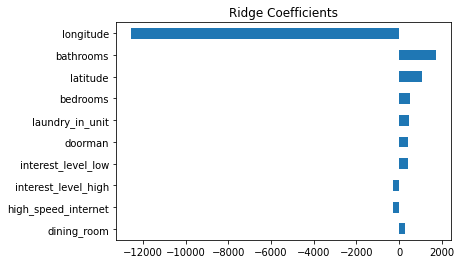

**Note:** Your figure shouldn't be identical to the one above. Your model will have different coefficients since it's been trained on different data. Only the formatting should be the same.

In [ ]:
coef = model_r.coef_
features = ohe.get_feature_names()
feat_imp = pd.Series(coef,index=features).sort_values(key=abs)
feat_imp.tail(10).plot(kind='barh')